**Target**:
> 1.   Add data augmentation to slightly increase the accuracy.
2. Observe change in accuracy compared to previous model's max accuracy.



**Results**:

> 1.   Parameters: 16030
2.   Best Training Accuracy: 99.16%
3.   Best Test Accuracy: 99.6%





**Analysis**:

> 1.   Model is underfitting.
2.   Accuracy seems to be improved by applying data augmentation but too many augmentations seem to impact the performance.















In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_set = torchvision.datasets.MNIST(root='/Data',
                                       train = True,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )
test_set = torchvision.datasets.MNIST(root='/Data',
                                       train = False,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )

Extracting /Data/MNIST/raw/train-images-idx3-ubyte.gz to /Data/MNIST/raw


Extracting /Data/MNIST/raw/train-labels-idx1-ubyte.gz to /Data/MNIST/raw



Extracting /Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Data/MNIST/raw


Extracting /Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(f"""Shape: {train_set.data.shape}
Minimum: {torch.min(train_set.transform(train_set.data.numpy()))}
Maximum: {torch.max(train_set.transform(train_set.data.numpy()))}
Mean: {torch.mean(train_set.transform(train_set.data.numpy()))}
Standard Deviation: {torch.std(train_set.transform(train_set.data.numpy()))}
Variance : {torch.var(train_set.transform(train_set.data.numpy()))}""")


Shape: torch.Size([60000, 28, 28])
Minimum: 0.0
Maximum: 1.0
Mean: 0.13066047430038452
Standard Deviation: 0.30810782313346863
Variance : 0.09493042528629303


In [ ]:
train_set.transform = transforms.Compose([
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])
test_set.transform =  transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])


In [ ]:
train_set.transform , test_set.transform

(Compose(
     RandomRotation(degrees=[-7.0, 7.0], resample=False, expand=False, fill=(1,))
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ), Compose(
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = 128,
                                           shuffle = True,
                                           pin_memory = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, 
                                          batch_size = 128,
                                          shuffle = True,
                                          pin_memory = True)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


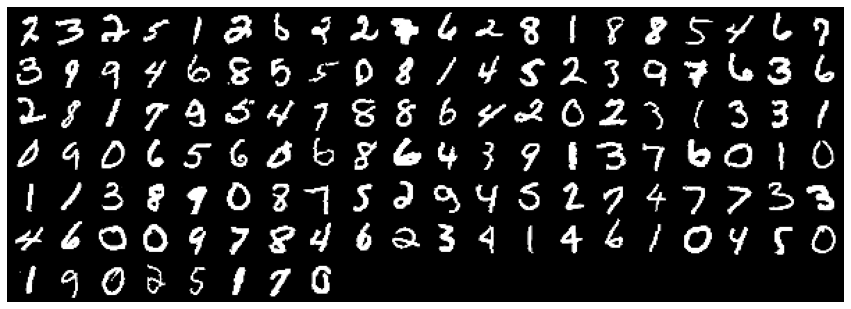

In [ ]:
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap = 'gray')
plt.axis('off')
plt.show()

In [ ]:
class CustomModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_Block1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.1)

    ) # Output size = 26
    self.conv_Block2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.1)
    ) # Output size = 24

    self.conv_Block3 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(0.1)
    ) # Output size = 22

    self.conv_Block4 = nn.Sequential(
        nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(0.1)
    ) # Output size = 20
    
    self.transition_block1 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 10   
         
    self.conv_Block5 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(0.1)
    ) # Output size = 8

    self.conv_Block6 = nn.Sequential(
        nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(0.1)
    ) # Output size = 6   

    self.conv_Block7 = nn.Sequential(
        nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(0.1)
    ) # Output size = 4
    
    self.gap = nn.AvgPool2d(kernel_size = 4) # Output size = 1

    self.merge_block1 = nn.Sequential(
        #nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 1

    

  def forward(self, image):
    image = self.conv_Block4(self.conv_Block3(self.conv_Block2(self.conv_Block1(image))))    
    image = self.transition_block1(image)
    image = self.conv_Block7(self.conv_Block6(self.conv_Block5(image)))
    image = self.gap(image)
    image = self.merge_block1(image)
    
    image = image.reshape(-1,10)
    return F.log_softmax(image, dim=-1)




In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = CustomModel().to(device) 
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
             ReLU-10           [-1, 20, 22, 22]               0
      BatchNorm2d-11           [-1, 20, 22, 22]              40
          Dropout-12           [-1, 20, 22, 22]               0
           Conv2d-13           [-1, 20, 20, 20]           3,600
             ReLU-14           [-1, 20,

In [ ]:
print(next(iter(model.parameters())),next(iter(model.parameters())).shape)

Parameter containing:
tensor([[[[ 0.2911, -0.2218,  0.2906],
          [ 0.1568,  0.3058,  0.2499],
          [-0.0851, -0.3264, -0.0360]]],


        [[[-0.1485, -0.0034,  0.2800],
          [-0.1132,  0.0237,  0.2581],
          [-0.2089, -0.3073,  0.2635]]],


        [[[ 0.2881,  0.2067, -0.1790],
          [ 0.0317, -0.1335,  0.1122],
          [ 0.1739, -0.2536, -0.2561]]],


        [[[-0.3182, -0.2978,  0.1695],
          [-0.1324, -0.1194,  0.2519],
          [ 0.2705,  0.1927, -0.1349]]],


        [[[-0.2861,  0.1473,  0.2124],
          [-0.0481, -0.3276,  0.0946],
          [-0.1014, -0.0303,  0.1205]]],


        [[[ 0.1532, -0.0967, -0.0096],
          [ 0.0153, -0.3268,  0.3040],
          [ 0.3274,  0.0626, -0.2998]]],


        [[[ 0.2527,  0.1127,  0.0827],
          [-0.1509, -0.2354, -0.0610],
          [-0.0789,  0.1660,  0.0975]]],


        [[[-0.2328,  0.2211, -0.0648],
          [-0.2478,  0.3275,  0.0506],
          [-0.0965,  0.2915,  0.1064]]],


        [[

# Training the entire set

In [ ]:
def train_model(model, device, train_loader, optimiser):
  train_loss, train_accuracy, total_train_correct, total_train_processed = 0, 0, 0, 0    
  model.train()
  for batch in train_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    optimiser.zero_grad()

    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss = F.nll_loss(pred, labels)
    train_loss += loss.item()

    loss.backward()
    optimiser.step()       
    
    total_train_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_train_processed += len(images)
    
  train_accuracy = 100*(total_train_correct/total_train_processed)
  train_loss /= len(train_loader.dataset) 
  return train_loss, train_accuracy  



def test_model(model, device, test_loader):
  test_loss, test_accuracy, total_test_correct, total_test_processed = 0, 0, 0, 0    
  model.eval()
  for batch in test_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    
    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss = F.nll_loss(pred, labels)
    test_loss += loss.item()          
    
    total_test_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_test_processed += len(images)
    
  test_accuracy = 100*(total_test_correct/total_test_processed)
  test_loss /= len(test_loader.dataset) 
  return test_loss, test_accuracy
  





In [ ]:
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [ ]:
def train_epochs(epochs, model, device, train_loader, optimiser, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, optimiser)    
    test_loss, test_accuracy = test_model(model, device, test_loader)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
  return train_losses, train_accuracies, test_losses, test_accuracies
  

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(15, model, device, train_loader, optimiser, test_loader)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.003053172 
Train Accuracy :  89.9333% 

Average Test Loss : 0.000424366 
Test Accuracy :  98.5400% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.000577094 
Train Accuracy :  97.9433% 

Average Test Loss : 0.000301849 
Test Accuracy :  98.9000% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.000435694 
Train Accuracy :  98.3567% 

Average Test Loss : 0.000225851 
Test Accuracy :  99.1200% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.000382072 
Train Accuracy :  98.5167% 

Average Test Loss : 0.000230032 
Test Accuracy :  99.1300% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.000340353 
Train Accuracy :  98.6717% 

Average Test Loss : 0.000188055 
Test Accuracy :  99.3200% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.000318920 
Train Accuracy :  98.7300% 

Average Test Loss : 0.000142146 
Test Accuracy :  99.3700% 


Epoch 7 in progress....

Epo

Text(0.5, 1.0, 'Test Accuracy')

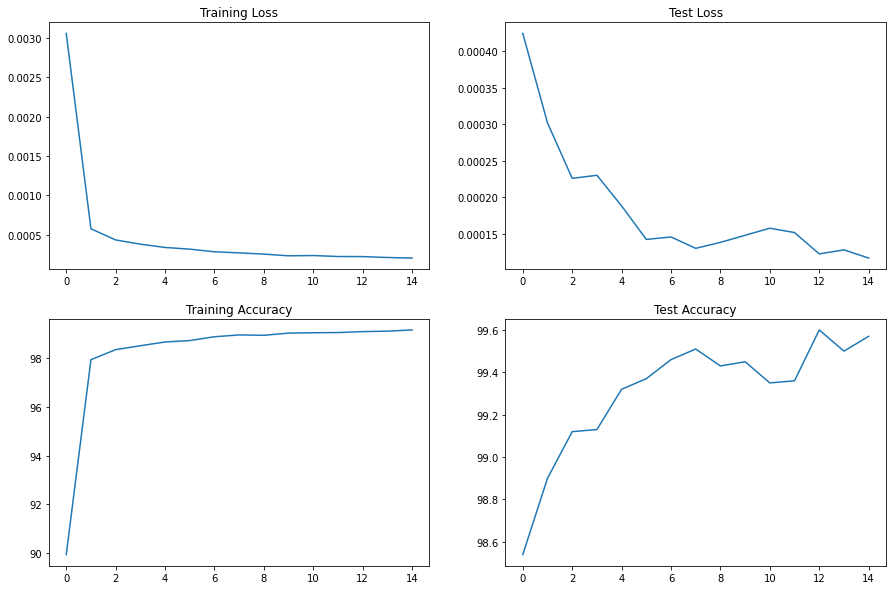

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")